# Notebook consists of several parts:
1. Data preparation 
  - Packages loading
  - Data importation as Dataframe
  - Data characterisation
  - Data importation as images
  - Vizualization of some images from dataset
  - Data augumentation
  
2. Model constraction based on Transfer Learning technique (base model is MobileNetV2)
3. Model compilation and training
4. Model evaluation
5. Model fine-tuning
6. Model training to get optimizied model parameters
7. Model evoluation after fine-tuning


# 1. Data preparation

## 1.1. Packages Loading

In [1]:
!pip uninstall -y yawbcc
!pip -q install git+https://github.com/corralien/yawbcc.git 2> /dev/null

Found existing installation: yawbcc 0.1.2
Uninstalling yawbcc-0.1.2:
  Successfully uninstalled yawbcc-0.1.2


In [ ]:
!pip install -q -U tensorflow tensorflow-addons keras

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib

2022-11-17 20:21:47.475147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1.2. Data importation
### Importation of dataset "Barcelona"

In [2]:
from yawbcc.datasets import load_barcelona_wbc
# creation of DataFrame
df = load_barcelona_wbc()
df.head()

,image,group,label,width,height,path
0,BA_689200.jpg,BASOPHIL,BA,360,363,/Users/Anastasiya/yawbcc_data/barcelona/basoph...
1,BA_883452.jpg,BASOPHIL,BA,360,363,/Users/Anastasiya/yawbcc_data/barcelona/basoph...
2,BA_382161.jpg,BASOPHIL,BA,366,369,/Users/Anastasiya/yawbcc_data/barcelona/basoph...
3,BA_175579.jpg,BASOPHIL,BA,360,363,/Users/Anastasiya/yawbcc_data/barcelona/basoph...
4,BA_775722.jpg,BASOPHIL,BA,360,363,/Users/Anastasiya/yawbcc_data/barcelona/basoph...


## 1.3. Creation of train, validation and test datasets

In [3]:
DATA_DIR = pathlib.Path.home() / 'yawbcc_data'

BATCH_SIZE = 32
IMG_SIZE = (128, 128)


train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR / 'barcelona', validation_split=0.2, subset='training', seed=2022,
                                        image_size=IMG_SIZE, batch_size=BATCH_SIZE, crop_to_aspect_ratio=True)

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR / 'barcelona', validation_split=0.2, subset='validation', seed=2022,
                                        image_size=IMG_SIZE, batch_size=BATCH_SIZE, crop_to_aspect_ratio=True)

# As the original dataset doesn't contain a test set, you will create one.
#To do so, determine how many batches of data are available in the validation set using
# tf.data.experimental.cardinality, then move 20% of them to a test set.

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
# Names of the clases
class_names = train_ds.class_names
# Number of classes
num_classes=len(class_names)
print('Class names:',class_names)
print('Number of classes:',num_classes)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.


2022-11-17 20:22:11.643372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 17092 files belonging to 8 classes.
Using 3418 files for validation.
Number of validation batches: 86
Number of test batches: 21
Number of train batches: 428
Class names: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Number of classes: 8


## 1.4. Image vizualisation

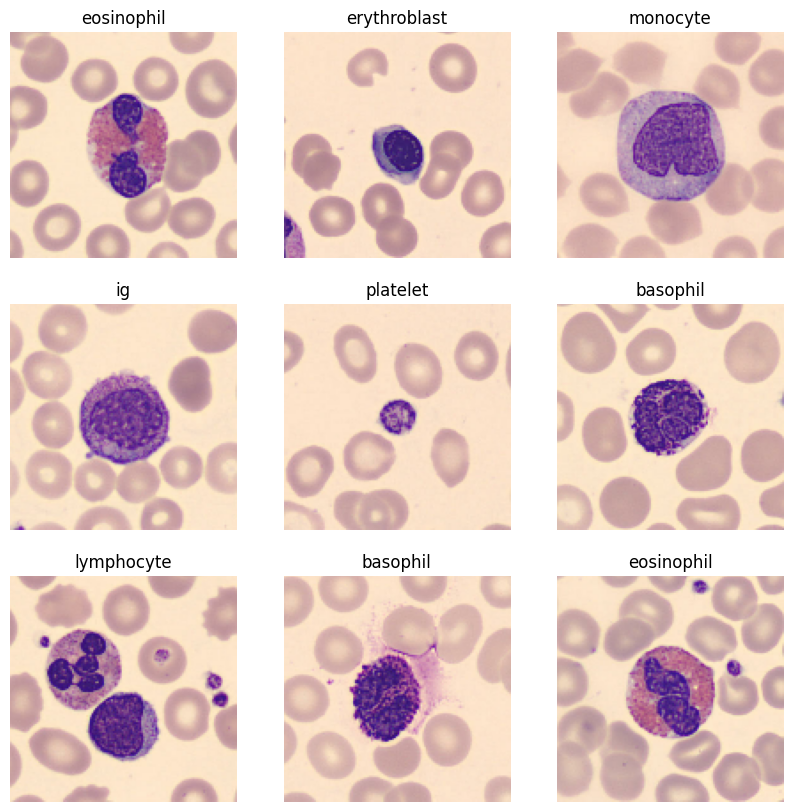

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 1.5. Configure the dataset for performance

In [5]:
# Use buffered prefetching to load images from disk without having I/O become blocking.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## 1.6. Data augmentation
When there is no large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as **rotation** and **horizontal flipping**. This helps expose the model to different aspects of the training data and reduce overfitting.

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# 2. Transfer Learning with MobileNetV2 as a base model

## 2.1. CNN Model construction using Transfer Learning technique 

In [7]:
# preprocessing as normalization specific to MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)
# creation of the base model  MobileNetV2 without last layers 
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# freezing wiegts of the base model
base_model.trainable = False

# The new layers for our base model that will be used in the following order
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
flatten=tf.keras.layers.Flatten()
dense_1=tf.keras.layers.Dense(32, activation='relu', name='fc1')
dense_2=tf.keras.layers.Dense(32, activation='relu', name='fc2')
prediction_layer= tf.keras.layers.Dense(8, activation='softmax', name='predictions')

9406464/9406464 [==============================] - 1s 0us/step


In [8]:
# connection of the layers
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = flatten(x)
x = dense_1(x)
x = dense_2(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs, name='MobileNetV2')
# our model summary
model.summary()

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                       

# 3. Model Compilation and Training

In [9]:
# model compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model training
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
428/428 [==============================] - 103s 232ms/step - loss: 0.4872 - accuracy: 0.8368 - val_loss: 0.2831 - val_accuracy: 0.9024
Epoch 2/10
428/428 [==============================] - 104s 243ms/step - loss: 0.2513 - accuracy: 0.9155 - val_loss: 0.2631 - val_accuracy: 0.9097
Epoch 3/10
428/428 [==============================] - 115s 268ms/step - loss: 0.2160 - accuracy: 0.9252 - val_loss: 0.2207 - val_accuracy: 0.9232
Epoch 4/10
428/428 [==============================] - 134s 314ms/step - loss: 0.1960 - accuracy: 0.9307 - val_loss: 0.2144 - val_accuracy: 0.9272
Epoch 5/10
428/428 [==============================] - 121s 283ms/step - loss: 0.1804 - accuracy: 0.9367 - val_loss: 0.1976 - val_accuracy: 0.9334
Epoch 6/10
428/428 [==============================] - 107s 250ms/step - loss: 0.1721 - accuracy: 0.9392 - val_loss: 0.1798 - val_accuracy: 0.9359
Epoch 7/10
428/428 [==============================] - 124s 290ms/step - loss: 0.1664 - accuracy: 0.9403 - val_loss: 0.1889 -

# 4. Model Evalution on Test dataset
## 4.1. Plotting Learning Curves

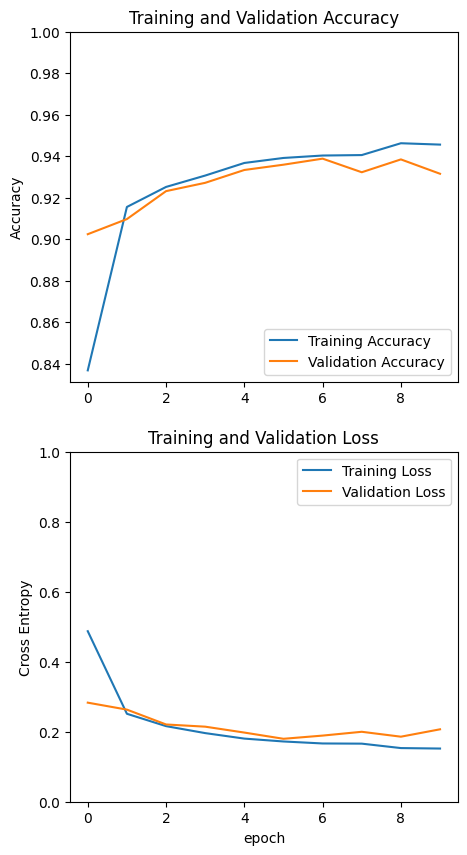

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(5, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 4.2. Plotting images with predicted labels

Predictions:
 [4 6 3 1 4 3 6 4 4 6 7 6 1 1 7 6 5 1 3 6 1 7 6 1 1 1 6 0 6 2 0 2]
Labels:
 [4 6 3 1 4 3 6 6 4 6 7 6 1 1 7 6 6 1 3 6 1 7 1 1 1 1 6 0 6 2 0 2]


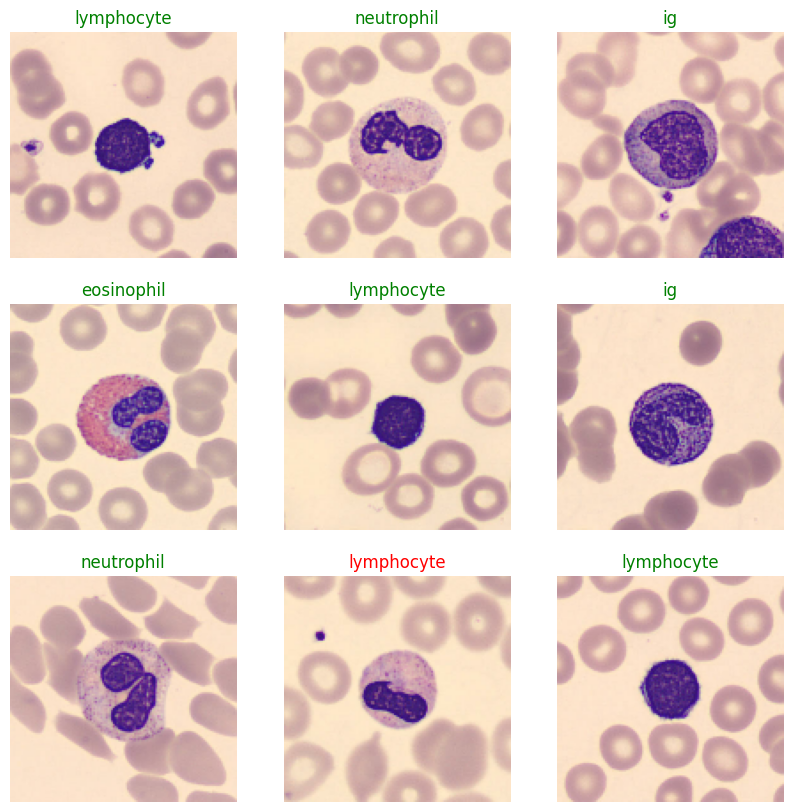

In [17]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).argmax(axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    if class_names[predictions[i]]== class_names[label_batch[i]]:
        color='g'
    else:
        color='r'
    plt.title(class_names[predictions[i]],c=color)
    plt.axis("off")

## 4.3. Classification report and Confusion Matrix 

In [18]:
from sklearn import metrics

print(metrics.classification_report(label_batch,predictions))
conf_matrix=metrics.confusion_matrix(label_batch,predictions)
print(conf_matrix)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       0.75      1.00      0.86         3
           5       0.00      0.00      0.00         0
           6       0.89      0.80      0.84        10
           7       1.00      1.00      1.00         3

    accuracy                           0.91        32
   macro avg       0.83      0.84      0.83        32
weighted avg       0.94      0.91      0.92        32

[[2 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 1 0]
 [0 0 2 0 0 0 0 0]
 [0 0 0 3 0 0 0 0]
 [0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 8 0]
 [0 0 0 0 0 0 0 3]]


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 5. Model Fine-tuning
## 5.1. Choosing number of parameters to tune

In [19]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


## 5.2. Model Compilation for fune-tuning approach and it's summary

In [20]:
# model compilation
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

In [21]:
# Summary of the Model for Fine-tuning
model.summary()

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                       

In [22]:
# Number of trainable model parametrs
len(model.trainable_variables)

60

# 6. Model training to get optimizied model parameters

In [23]:
initial_epochs=10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
428/428 [==============================] - 153s 348ms/step - loss: 0.1524 - accuracy: 0.9477 - val_loss: 0.1663 - val_accuracy: 0.9425
Epoch 11/20
428/428 [==============================] - 143s 334ms/step - loss: 0.1283 - accuracy: 0.9558 - val_loss: 0.1487 - val_accuracy: 0.9519
Epoch 12/20
428/428 [==============================] - 133s 311ms/step - loss: 0.1109 - accuracy: 0.9591 - val_loss: 0.1519 - val_accuracy: 0.9497
Epoch 13/20
428/428 [==============================] - 150s 351ms/step - loss: 0.1076 - accuracy: 0.9615 - val_loss: 0.1607 - val_accuracy: 0.9497
Epoch 14/20
428/428 [==============================] - 137s 320ms/step - loss: 0.0973 - accuracy: 0.9653 - val_loss: 0.1270 - val_accuracy: 0.9574
Epoch 15/20
428/428 [==============================] - 141s 329ms/step - loss: 0.0876 - accuracy: 0.9695 - val_loss: 0.1151 - val_accuracy: 0.9610
Epoch 16/20
428/428 [==============================] - 141s 328ms/step - loss: 0.0853 - accuracy: 0.9713 - val_loss: 0

# 7. Model Evaluation after fine-tuning
## 7.1. Plotting learning curves

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

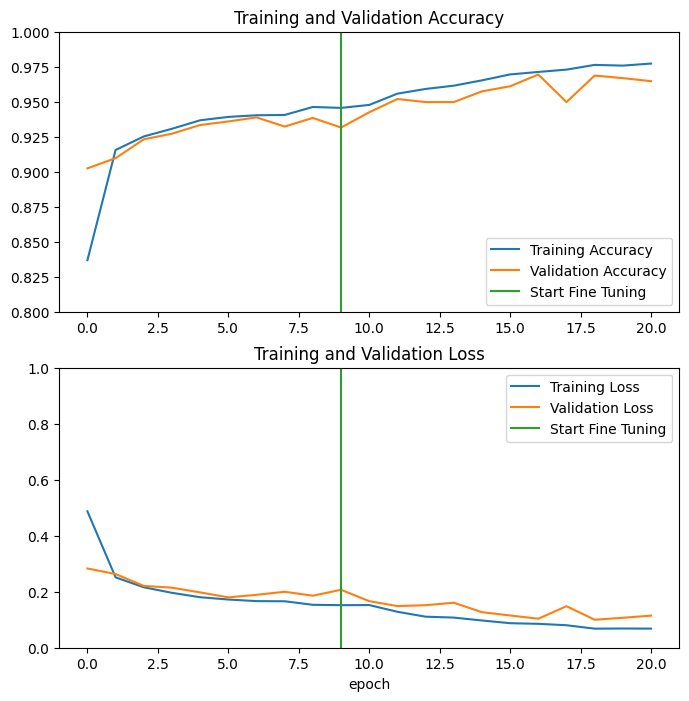

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 7.2. Plotting images with predicted labels

Predictions:
 [3 0 2 7 7 5 6 7 2 1 3 5 6 3 2 6 0 6 4 7 1 1 3 7 4 3 3 1 4 6 1 1]
Labels:
 [3 0 2 7 7 5 6 7 2 1 6 5 6 3 2 6 0 6 4 7 1 1 3 7 4 5 3 1 4 6 1 1]


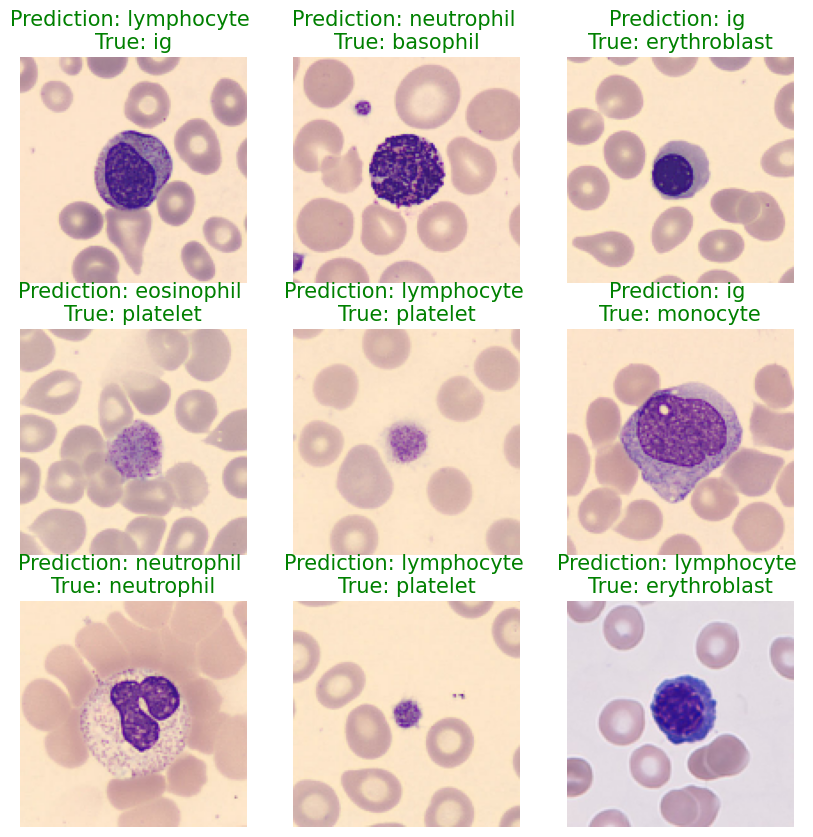

In [29]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions_ft = model.predict_on_batch(image_batch).argmax(axis=1)

print('Predictions:\n', predictions_ft)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    if predictions_ft[i]== label_batch[i]:
        color='g'
    else:
        color='r'
    plt.title(f'Prediction: {class_names[predictions[i]]} \nTrue: {class_names[label_batch[i]]}',
              fontsize=15, c=color)
    plt.axis("off")

## 7.3. Classification report and Confusion Matrix

In [30]:
# Classification report and confusion matrix for the 1st BATCH of test_ds

from sklearn import metrics

print(metrics.classification_report(label_batch,predictions_ft))
conf_matrix_ft=metrics.confusion_matrix(label_batch,predictions_ft)
print(conf_matrix_ft)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       0.67      1.00      0.80         4
           4       1.00      1.00      1.00         3
           5       1.00      0.67      0.80         3
           6       1.00      0.83      0.91         6
           7       1.00      1.00      1.00         5

    accuracy                           0.94        32
   macro avg       0.96      0.94      0.94        32
weighted avg       0.96      0.94      0.94        32

[[2 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0]
 [0 0 0 4 0 0 0 0]
 [0 0 0 0 3 0 0 0]
 [0 0 0 1 0 2 0 0]
 [0 0 0 1 0 0 5 0]
 [0 0 0 0 0 0 0 5]]


In [31]:
# Classification report and confusion matrix for ALL test_ds

L_true=[] # true labels of test_ds; it is a list os lists, eaach elemnt is a list coresponding to a BATCH
P=[] # predictions on test_ds; it is a list os lists, eaach elemnt is a list coresponding to a BATCH
for element in test_ds.as_numpy_iterator(): 
    image_batch, label_batch = test_ds.as_numpy_iterator().next() # iteration batch by batch
    predictions_ft = model.predict_on_batch(image_batch).argmax(axis=1) # predictions
    L_true.append(label_batch) # addition to the list 
    P.append(predictions_ft)  # addition to the list 

all_L_true = np.concatenate(L_true) # getting a LIST of true labes od test_ds from list of lists
all_P = np.concatenate(P) # # getting a LIST of true labes od test_ds from list of lists

# classification report
print(metrics.classification_report(all_L_true,all_P))

# confusion matrix
conf_matrix_ft_ALL=metrics.confusion_matrix(all_L_true,all_P)
print(conf_matrix_ft_ALL)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        52
           1       1.00      1.00      1.00       122
           2       1.00      0.92      0.96        37
           3       0.86      0.94      0.90        98
           4       0.94      1.00      0.97        65
           5       0.95      0.89      0.92        66
           6       1.00      0.94      0.97       145
           7       1.00      1.00      1.00        87

    accuracy                           0.96       672
   macro avg       0.96      0.96      0.96       672
weighted avg       0.96      0.96      0.96       672

[[ 52   0   0   0   0   0   0   0]
 [  0 122   0   0   0   0   0   0]
 [  0   0  34   3   0   0   0   0]
 [  3   0   0  92   0   3   0   0]
 [  0   0   0   0  65   0   0   0]
 [  0   0   0   3   4  59   0   0]
 [  0   0   0   9   0   0 136   0]
 [  0   0   0   0   0   0   0  87]]


In [ ]:
#model.save('TL_MobileNetV2_Barcelona_8112022')